# 1. Install libraries

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
from brian2 import *
prefs.codegen.target = 'numpy'  # use the Python fallback (cython bugs for some reason)

# 2. Define parameters

In [73]:
start_scope()

## 2.1 Memory preferences

In [74]:
memory_intensive = False

if memory_intensive:
    numberNeuronGroups = 100
    neuronGroupSize = 50
    simulation_duration = 1000 * second
else:
    numberNeuronGroups = 10
    neuronGroupSize = 10
    simulation_duration = 30 * second

## 2.2 Neuron parameters

In [75]:
taum = 1*ms # neuron equation time constant
Ee = 0*mV # excitatory synapse equilibrium potential
vt = -54*mV # threshold potential
vr = -70*mV # resting potential
El = -70*mV # leak channel potential
taue = 0.5*ms # synaptic conductance time constant

## 2.3 STDP parameters

In [76]:
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

## 2.4 Dopamine signaling parameters

In [77]:
tauc = 1000*ms # eligibility time constant
taud = 200*ms # dopamine release time constant
taus = 1*ms # synaptic weight constant 
epsilon_dopa = 5e-3 # amount of dopamine released on reward

# 3. Build a network

Initialize the network:

In [78]:
network = Network()

## 3.1 Main neuron group
### 3.1.1 Neurons

In [79]:
neurons = NeuronGroup(numberNeuronGroups*neuronGroupSize,  '''dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
                                      dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='linear')
neurons.v = vr
network.add(neurons)


### 3.1.2 STDP Synapses

In [80]:
epsilon = 0.1 # sparseness of synaptic connections
synapse_stdp = Synapses(neurons, neurons,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                   on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                     method='''euler'''
                   )

Connectivity: make sure a neuron does not form a synapse with itself

In [81]:
synapse_stdp.connect(condition = 'i!=j', p=epsilon)

Initialize synapse parameters

In [82]:
synapse_stdp.mode = 1
synapse_stdp.s = 1e-9
synapse_stdp.c = 1e-9
synapse_stdp.d = 0

Add synapse to network

In [83]:
network.add(synapse_stdp)

## 3.2 Input: stimuli and noise
### 3.2.1 Stimuli

In [84]:
numberStimulations = int((1000*simulation_duration/second - 100)/200) # stimulus every ~200 seconds
input_times = np.array([100 + 200*i + np.random.randint(-50, 50) for i in range(numberStimulations)])*ms # define when the stimuli happen 
input_indices = np.array([np.random.randint(0, numberNeuronGroups) for i in range(numberStimulations)]) # define which group each pulse targets
groupedStimuli = SpikeGeneratorGroup(numberNeuronGroups,input_indices, input_times)
network.add(groupedStimuli)

### 3.2.2 Synapse between stimuli and main neuron group

In [85]:
inputSynapse = Synapses(groupedStimuli, neurons, model='''s : volt''', on_pre='v += s') # every time an input fires the corresponding neurons are depolarized beyond threshold
for k in range(numberNeuronGroups):
       inputSynapse.connect(i=[k], j=list(range(neuronGroupSize*k + 1, neuronGroupSize*(k+1)))) # input i is connected to all the neurons in the group Si
inputSynapse.s = 100*mV # enough to guarantee a postsynaptic spike
network.add(inputSynapse)

### 3.2.3 Noise

In [86]:
noise_rate = 2*Hz
noise = PoissonGroup(numberNeuronGroups*neuronGroupSize, noise_rate)
network.add(noise)

### 3.2.4 Synapse between stimuli and main neuron group

In [87]:
noiseSynapse = Synapses(noise, neurons, model='''s : volt''', on_pre='v += s')
noiseSynapse.connect(condition = 'i==j', p = 1.)
noiseSynapse.s = 100*mV # enough to guarantee a postsynaptic spike
network.add(noiseSynapse)

## 3.3 Dopamine signalling

In [88]:
dopamine = NeuronGroup(1, '''v : volt''', threshold='v>1*volt', reset='v=0*volt')
network.add(dopamine)

Monitor when dopamine is released:

In [89]:
dopamine_monitor = SpikeMonitor(dopamine)
network.add(dopamine_monitor)

### 3.3.1 Synapse ordering dopamine release when the conditioning stimulus occurs

In [90]:
conditioning = Synapses(groupedStimuli, dopamine, on_pre='''v_post += 2*volt''', method='exact') # 2*volt is bigger than the dopamine neuron's 1*volt threshold
conditioning.connect(i  = 0, j = 0)
network.add(conditioning)

### 3.3.2 Synapse accounting for the effect of dopamine on plasticity

In [91]:
reward = Synapses(dopamine, synapse_stdp, on_pre='''d_post += epsilon_dopa''', method='exact')
reward.connect(p=1.) # every synapse is affected by dopamine
reward.delay='100*ms' # dopamine reaches the synapse 100ms after the conditioning stimulus
network.add(reward)



# 4. Simulation
## 4.1 Launch simulation

In [92]:
# Classical STDP
# synapse_stdp.mode = 0

# Dopamine modulated STDP
synapse_stdp.mode = 1
neuronSpikes = SpikeMonitor(neurons, record=True)
network.add(neuronSpikes)
network.run(simulation_duration, report='text')

Starting simulation at t=0. s for a duration of 30. s
3.8245 (12%) simulated in 10s, estimated 1m 8s remaining.
7.595999999999999 (25%) simulated in 20s, estimated 59s remaining.
11.1704 (37%) simulated in 30s, estimated 51s remaining.
14.7238 (49%) simulated in 40s, estimated 42s remaining.
18.177400000000002 (60%) simulated in 50s, estimated 33s remaining.
21.3668 (71%) simulated in 1m 0s, estimated 24s remaining.
24.868000000000002 (82%) simulated in 1m 10s, estimated 14s remaining.
29.142000000000003 (97%) simulated in 1m 20s, estimated 2s remaining.
30.0 (100%) simulated in 1m 22s


## 4.2 Display results

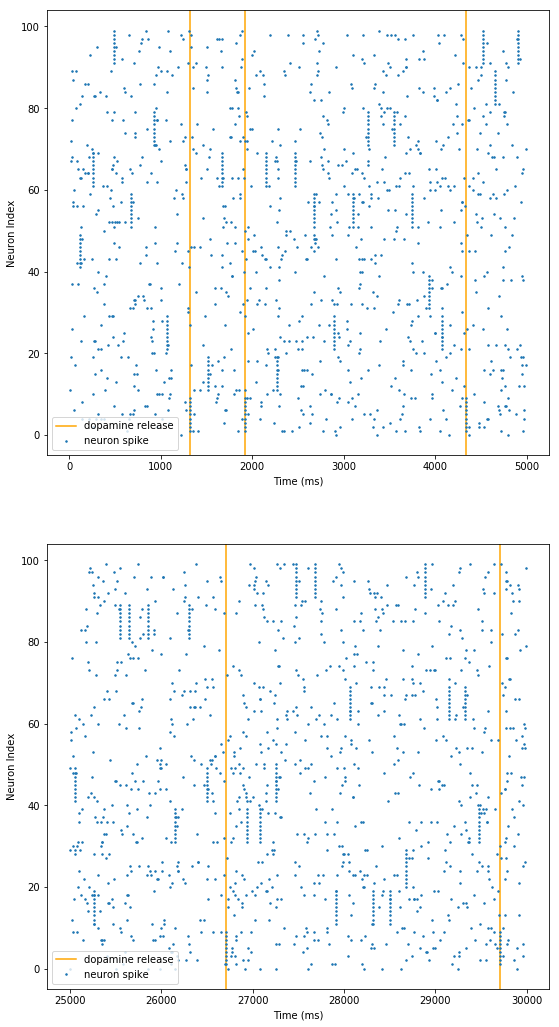

In [93]:
figure(figsize=(9,18))
subplot(211)
rewardTimes = [t for t in dopamine_monitor.t/ms if t < 5000]
if len(rewardTimes) > 0:
   plt.axvline(x = rewardTimes[0], linestyle = '-', color = 'orange', label='dopamine release')
for rewardTime in rewardTimes[1:]:
   plt.axvline(x = rewardTime, linestyle = '-', color = 'orange')
spikeTimes = [t for t in neuronSpikes.t/ms if t < 5000]
spikeIndex = neuronSpikes.i[:len(spikeTimes)]
plt.plot(spikeTimes, spikeIndex, '.', markersize=3, label='neuron spike')
ylabel('Neuron Index')
xlabel('Time (ms)')
plt.legend()
subplot(212)
rewardTimes = [t for t in dopamine_monitor.t/ms if t > simulation_duration*1000/second-5000]
if len(rewardTimes) > 0:
   plt.axvline(x = rewardTimes[0], linestyle = '-', color = 'orange', label='dopamine release')
for rewardTime in rewardTimes[1:]:
   plt.axvline(x = rewardTime, linestyle = '-', color = 'orange')
spikeTimes = [t for t in neuronSpikes.t/ms if t > simulation_duration*1000/second-5000]
spikeIndex = neuronSpikes.i[-len(spikeTimes):]
plt.plot(spikeTimes, spikeIndex, '.', markersize=3, label='neuron spike')
ylabel('Neuron Index')
xlabel('Time (ms)')
plt.legend()
show()
